In [22]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, RationalQuadratic, DotProduct
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [23]:
# define functions

def f(T, m, Tc=1.25):
    return 0.5*(1-Tc/T)*m**2 + (Tc/T)**3*m**4/12

def compute_bic(gp: GaussianProcessRegressor, X: np.ndarray, y:np.ndarray) -> float:
    """
    Compute the Bayesian Information Criterion (BIC) for a given Gaussian Process model.
    
    Parameters:
    gp (GaussianProcessRegressor): The fitted Gaussian Process model.
    X (np.ndarray): The input data used to fit the model.
    y (np.ndarray): The target values used to fit the model.
    
    Returns:
    float: The BIC value.
    """
    n = X.shape[0]
    k = gp.kernel_.theta.shape[0]
    log_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    
    bic = log_likelihood - 0.5 * k * np.log(n)
    return bic

base_kernels = {
    'LIN': ConstantKernel(1.0) * DotProduct(),
    'RBF': ConstantKernel(1.0) * RBF(length_scale=1.0),
    'Matern': ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5),
    'RationalQuadratic': ConstantKernel(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)
}

def iterative_kernel_search(X:np.ndarray, y:np.ndarray, base_kernels:dict=base_kernels, max_iter: int =10):
    """Algorithm for determining the best kernel for a Gaussian Process model using iterative kernel search."""
    bic_scores = {}
    for name, kernel in base_kernels.items():
        gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
        gp.fit(X, y)
        bic_scores[name] = compute_bic(gp, X, y)
    best_name = max(bic_scores, key=bic_scores.get)
    best_kernel = base_kernels[best_name]
    best_bic = bic_scores[best_name]

    for _ in range(max_iter):
        candidates = {}
        for name, kernel in base_kernels.items():
            if name == best_name:
                continue
            for op, combo_k in [('+', best_kernel + kernel), ('*', best_kernel * kernel)]:
                combo_name = f"{best_name}{op}{name}"
                gp = GaussianProcessRegressor(kernel=combo_k, normalize_y=True)
                gp.fit(X, y)
                bic_val = compute_bic(gp, X, y)
                candidates[combo_name] = (bic_val, combo_k)
        combo_name, (combo_bic, combo_k) = max(candidates.items(), key=lambda item: item[1][0])
        if combo_bic > best_bic:
            best_name = combo_name
            best_kernel = combo_k
            best_bic = combo_bic
        else:
            break
    return best_kernel

def build_rectangles(T, m):
    """Build rectangles for full, training, and testing datasets."""
    T_mid = (T.min() + T.max()) / 2

    R_full = {
        'T_min': T.min(), 'T_max': T.max(),
        'm_min': m.min(), 'm_max': m.max()
    }

    R_train = {
        'T_min': T_mid, 'T_max': T.max(),
        'm_min': m.min(), 'm_max': m.max()
    }

    R_test = {
        'T_min': T.min(), 'T_max': T_mid,
        'm_min': m.min(), 'm_max': m.max()
    }
    return R_full, R_train, R_test

def mask_in_rect(T, m, R):
    """Create a boolean mask for points inside the rectangle R in the (T, m) space."""
    return (
        (T >= R['T_min']) & (T <= R['T_max']) &
        (m >= R['m_min']) & (m <= R['m_max'])
    )
def rect_area(R):
    """Compute the area of a rectangle."""
    return (R['T_max'] - R['T_min']) * (R['m_max'] - R['m_min'])


In [24]:
# parameters and dataset

Tc = 1.25
degrees = [x for x in range(2, 13)]
alpha = 1e-5

np.random.seed(42)
N = 10000
T = np.random.uniform(0.8, 2.2, N)
m = np.random.uniform(-1.25, 1.25, N)
y = f(T, m)

R_full, R_train, R_test = build_rectangles(T, m)

mask_train = mask_in_rect(T, m, R_train)
mask_test = mask_in_rect(T, m, R_test)

print(f"Training samples: {mask_train.sum()}, Testing samples: {mask_test.sum()}")

A_full = rect_area(R_full)
A_train = rect_area(R_train)
A_test = rect_area(R_test) 

print(f"Training Area: {A_train}, Testing Area: {A_test}, Full Area: {A_full}")
rho_P = A_full / A_train
rho_Q = A_full / A_test

Training samples: 4925, Testing samples: 5075
Training Area: 1.749078081195772, Testing Area: 1.7490780811957725, Full Area: 3.4981561623915445


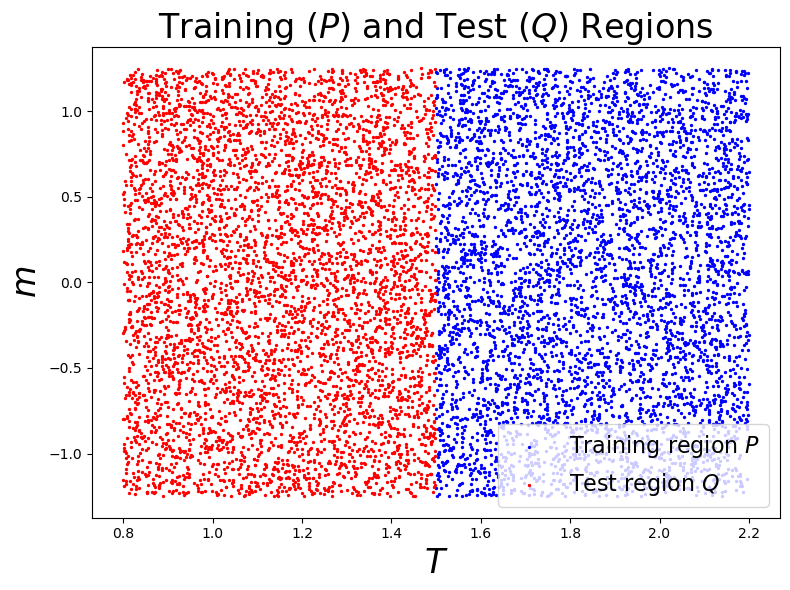

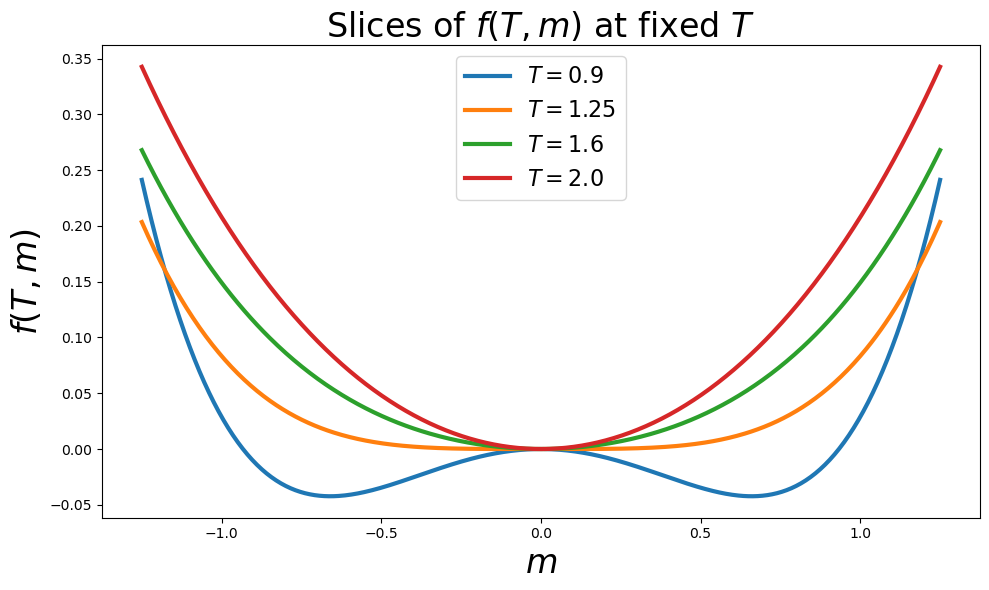

Text(0.5, 1.0, 'Order Parameter $m^*(T)$')

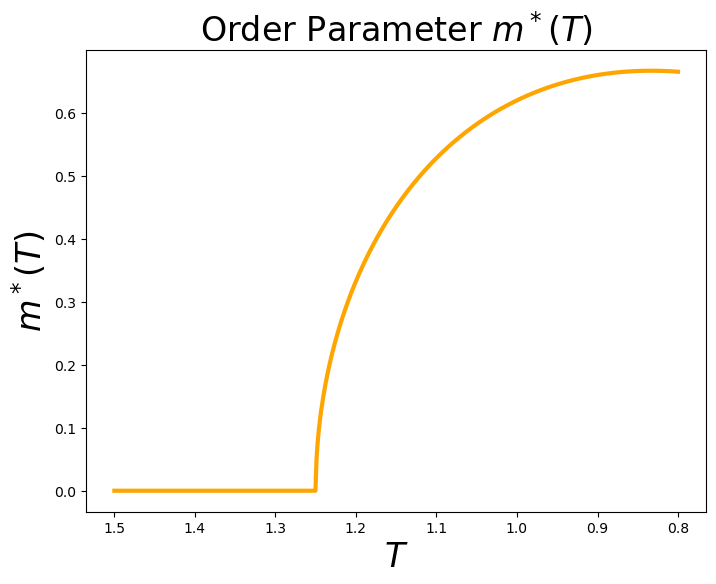

In [25]:
# Visualize training and test regions with LaTeX formatting

plt.figure(figsize=(8, 6))
plt.scatter(T[mask_train], m[mask_train], s=2, color='blue', label=r'Training region $P$')
plt.scatter(T[mask_test], m[mask_test], s=2, color='red', label=r'Test region $Q$')
plt.xlabel(r"$T$", fontsize=24)
plt.ylabel(r"$m$", fontsize=24)
plt.title(r"Training ($P$) and Test ($Q$) Regions", fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()


# Visualize f(T, m) slices for several fixed T values and show order parameter m

T_slices = [0.9, 1.25, 1.6, 2.0]
m_vals = np.linspace(-1.25, 1.25, 500)

plt.figure(figsize=(10, 6))
for T_val in T_slices:
    plt.plot(m_vals, f(T_val, m_vals), label=fr"$T={T_val}$", linewidth=3)
plt.xlabel(r"$m$", fontsize=24)
plt.ylabel(r"$f(T, m)$", fontsize=24)
plt.title(r"Slices of $f(T, m)$ at fixed $T$", fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

# Calculate the minimizing m*(T) analytically for f(T, m)

def m0_exact(T, Tc=1.25):
    val = -3 * (1 - Tc / T) / ((Tc / T)**3)
    return np.sqrt(np.clip(val, 0, None))

T_plot = np.linspace(0.8, 1.5, 500)
m_star_ana = m0_exact(T_plot, Tc=Tc)
plt.figure(figsize=(8, 6))
# reverse the x axis
plt.gca().invert_xaxis()
plt.plot(T_plot, m_star_ana, linewidth=3, color='orange', label='Analytic $m^*(T)$')
plt.xlabel(r"$T$", fontsize=24)
plt.ylabel(r"$m^*(T)$", fontsize=24)
plt.title(r"Order Parameter $m^*(T)$", fontsize=24)

In [26]:
# gaussian process analysis

X_train_gp = np.column_stack((T[mask_train], m[mask_train]))
X_test_gp = np.column_stack((T[mask_test], m[mask_test]))
y_train_gp = y[mask_train]
y_test_gp = y[mask_test]

best_kernel = iterative_kernel_search(X_train_gp, y_train_gp)
gp = GaussianProcessRegressor(kernel=best_kernel, normalize_y=True)
gp.fit(X_train_gp, y_train_gp)

y_train_gp_pred = gp.predict(X_train_gp)
y_test_gp_pred = gp.predict(X_test_gp)

gp_train_mae = mean_absolute_error(y_train_gp, y_train_gp_pred)
gp_train_mse = mean_squared_error(y_train_gp, y_train_gp_pred)
gp_test_mae = mean_absolute_error(y_test_gp, y_test_gp_pred)
gp_test_mse = mean_squared_error(y_test_gp, y_test_gp_pred)

KeyboardInterrupt: 

In [27]:
print(best_kernel)
print("GP Train MSE:", gp_train_mse, "GP Test MSE:", gp_test_mse)

NameError: name 'best_kernel' is not defined

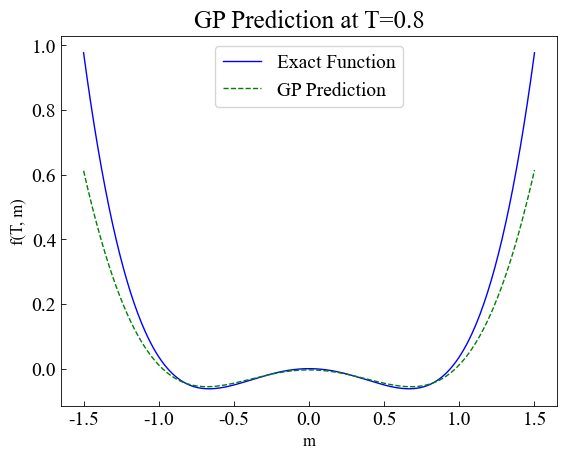

In [ ]:
T_val = 0.8
m_vals = np.linspace(-1.5, 1.5, 500)
X_test = np.vstack([np.full_like(m_vals, T_val), m_vals]).T
f_pred = gp.predict(X_test)
f_true = f(T_val, m_vals)

plt.plot(m_vals, f_true, label='Exact Function', color='blue')
plt.plot(m_vals, f_pred, label='GP Prediction', color='green', linestyle='--')
plt.title(f"GP Prediction at T={T_val}")
plt.xlabel("m")
plt.ylabel("f(T, m)")
plt.legend()
plt.show()

In [28]:
# polynomial analysis
train_maes = []
test_maes = []
train_mses = []
test_mses = []
bound_abs_Cdd = []
bound_mse_Cdd = []
bound_abs_remez = []
bound_mse_remez = []
n = 2  # dimension of input space

degrees = [x for x in range(2, 13)]

for d in degrees: 
    print(f"Degree {d}")

    X_train_poly = np.column_stack([T[mask_train], m[mask_train]])
    X_test_poly = np.column_stack([T[mask_test], m[mask_test]])
    y_train_poly = y[mask_train]
    y_test_poly = y[mask_test]

    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=d, include_bias=True)),
        ('ridge', Ridge(alpha=alpha))
    ])

    poly_model.fit(X_train_poly, y_train_poly)
    y_train_pred = poly_model.predict(X_train_poly)
    y_test_pred = poly_model.predict(X_test_poly)

    train_mae = mean_absolute_error(y_train_poly, y_train_pred)
    test_mae = mean_absolute_error(y_test_poly, y_test_pred)
    train_mse = mean_squared_error(y_train_poly, y_train_pred)
    test_mse = mean_squared_error(y_test_poly, y_test_pred)

    train_maes.append(train_mae)
    test_maes.append(test_mae)
    train_mses.append(train_mse)
    test_mses.append(test_mse)

    # Classical bounds
    bound_abs_Cdd.append((d**d)*rho_Q*(rho_P**d)*train_mae)
    bound_mse_Cdd.append(((2*d)**(2*d))*rho_Q*(rho_P**(2*d))*train_mse)

    # Remez exchange bounds
    sup_abs_remez = np.max(np.abs(y_train_poly - y_train_pred))
    sup_mse_remez = np.max((y_train_poly - y_train_pred)**2)

    bound_abs_remez.append((4 * n * rho_Q)**d * sup_abs_remez)
    bound_mse_remez.append((4 * n * rho_Q)**(2*d) * sup_mse_remez)

    # plt.figure()
    # T_val = 2.0
    # m_vals = np.linspace(-1.5, 1.5, 500)
    # X_test = np.vstack([np.full_like(m_vals, T_val), m_vals]).T
    # f_pred = poly_model.predict(X_test)
    # f_true = f(T_val, m_vals)

    # plt.plot(m_vals, f_true, label='Exact Function', color='blue')
    # plt.plot(m_vals, f_pred, label=f'Poly Degree {d}', color='red', linestyle='--')
    # plt.title(f"Poly Degree {d} Prediction at T={T_val}")
    # plt.xlabel("m")
    # plt.ylabel("f(T, m)")

Degree 2
Degree 3
Degree 4
Degree 5
Degree 6
Degree 7
Degree 8
Degree 9
Degree 10
Degree 11
Degree 12


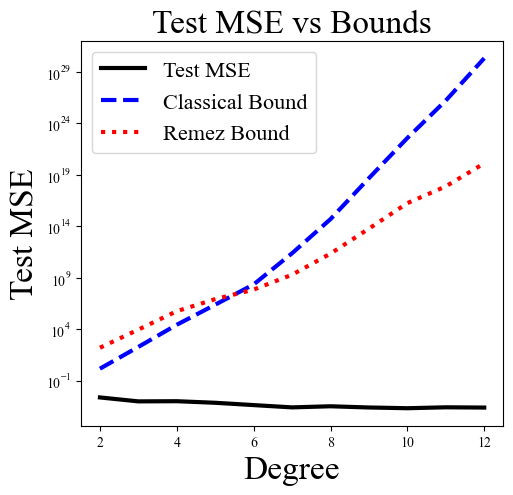

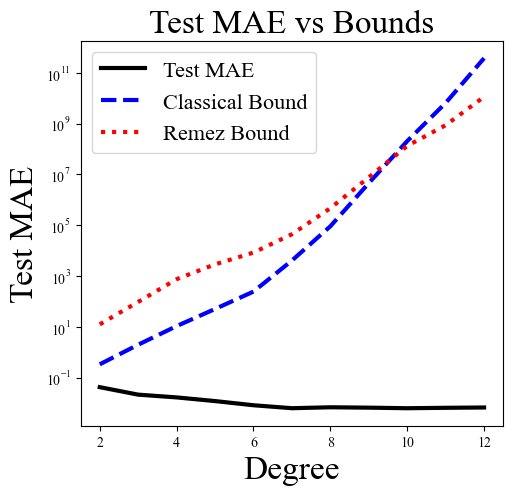

In [34]:
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12, 5))
# MSE comparison
plt.subplot(1, 2, 1)
plt.plot(degrees, test_mses, linewidth=3, label='Test MSE', color='black')
plt.plot(degrees, bound_mse_Cdd, linewidth=3, linestyle='--', label='Classical Bound', color='blue')
plt.plot(degrees, bound_mse_remez, linewidth=3, linestyle=':', label='Remez Bound', color='red')
plt.xlabel('Degree', fontsize=24)
plt.ylabel('Test MSE', fontsize=24)
plt.title('Test MSE vs Bounds', fontsize=24)
plt.yscale('log')
plt.legend(fontsize=16)

plt.figure(figsize=(12, 5))

# MAE comparison
plt.subplot(1, 2, 2)
plt.plot(degrees, test_maes, linewidth=3, label='Test MAE', color='black')
plt.plot(degrees, bound_abs_Cdd, linewidth=3, linestyle='--', label='Classical Bound', color='blue')
plt.plot(degrees, bound_abs_remez, linewidth=3, linestyle=':', label='Remez Bound', color='red')
plt.xlabel('Degree', fontsize=24)
plt.ylabel('Test MAE', fontsize=24)
plt.title('Test MAE vs Bounds', fontsize=24)
plt.yscale('log')
plt.legend(fontsize=16)

plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

# MSE comparison
plt.subplot(1, 2, 1)
plt.plot(degrees, test_mses, linewidth=3, label='Test MSE', color='black')
plt.plot(degrees, bound_mse_Cdd, linewidth=3, linestyle='--', label='Classical Bound', color='blue')
plt.plot(degrees, bound_mse_remez, linewidth=3, linestyle=':', label='Remez Bound', color='red')
plt.xlabel('Degree', fontsize=24)
plt.ylabel('Test MSE', fontsize=24)
plt.title('Test MSE vs Bounds', fontsize=24)
plt.yscale('log')
plt.legend()

# MAE comparison
plt.subplot(1, 2, 2)
plt.plot(degrees, test_maes, linewidth=3, label='Test MAE', color='black')
plt.plot(degrees, bound_abs_Cdd, linewidth=3, linestyle='--', label='Classical Bound', color='blue')
plt.plot(degrees, bound_abs_remez, linewidth=3, linestyle=':', label='Remez Bound', color='red')
plt.xlabel('Degree', fontsize=24)
plt.ylabel('Test MAE', fontsize=24)
plt.title('Test MAE vs Bounds', fontsize=24)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# get dominating polynomial terms

coefficients = poly_model.named_steps['ridge'].coef_

feature_names = poly_model.named_steps['poly'].get_feature_names_out(input_features=['T', 'm'])

# get dominating terms
dominant_terms = feature_names[np.argsort(np.abs(coefficients))[::-1]][:5]
print(dominant_terms)


['m^2' 'm^4' 'T^3 m^2' 'T^4 m^2' 'T m^2']


In [36]:
# neural networks
X_train_nn = np.column_stack([T[mask_train], m[mask_train]])
y_train_nn = y[mask_train]
X_test_nn = np.column_stack([T[mask_test], m[mask_test]])
y_test_nn = y[mask_test]

scaler = StandardScaler().fit(X_train_nn)
X_train_nn = scaler.transform(X_train_nn)
X_test_nn = scaler.transform(X_test_nn)

y_mean = y_train_nn.mean()
y_std = y_train_nn.std()
y_train_nn = (y_train_nn - y_mean) / y_std

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 128),
    activation='tanh',
    solver='adam',
    learning_rate='adaptive',     
    learning_rate_init=1e-3,
    alpha=0,           
    batch_size=1024,
    max_iter=100000,
    tol=0,
    n_iter_no_change=1000,
    random_state=0,
    early_stopping=False
)

mlp.fit(X_train_nn, y_train_nn)

# plt.plot(mlp.loss_)
# plt.yscale("log")   # optional, for clarity
# plt.xlabel("Epoch")
# plt.ylabel("Training loss (MSE)")
# plt.title("MLP Training Loss Curve")
# plt.show()

y_train_nn_pred = mlp.predict(X_train_nn)
y_test_nn_pred = mlp.predict(X_test_nn)

y_train_nn_pred = (y_train_nn_pred * y_std) + y_mean
y_test_nn_pred = (y_test_nn_pred * y_std) + y_mean
y_train_nn = (y_train_nn * y_std) + y_mean

nn_train_mae = mean_absolute_error(y_train_nn, y_train_nn_pred)
nn_test_mae = mean_absolute_error(y_test_nn, y_test_nn_pred)
nn_train_mse = mean_squared_error(y_train_nn, y_train_nn_pred)
nn_test_mse = mean_squared_error(y_test_nn, y_test_nn_pred)

print(f"NN Train MAE: {nn_train_mae}, NN Test MAE: {nn_test_mae}")
print(f"NN Train MSE: {nn_train_mse}, NN Test MSE: {nn_test_mse}")


NN Train MAE: 0.00010520972677595574, NN Test MAE: 0.009157502184099263
NN Train MSE: 1.4803248959759756e-08, NN Test MSE: 0.00047392018796616256


Text(0, 0.5, 'f(T, m)')

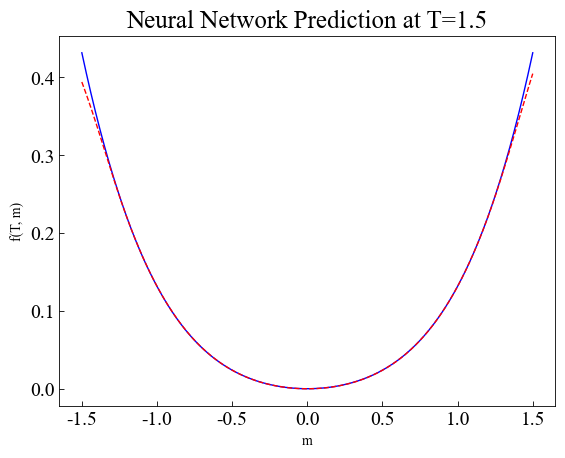

In [47]:
T_val = 1.5
m_vals = np.linspace(-1.5, 1.5, 1000)
X_test = np.vstack([np.full_like(m_vals, T_val), m_vals]).T
X_test = scaler.transform(X_test)
f_pred = mlp.predict(X_test)
f_pred = (f_pred * y_std) + y_mean
f_true = f(T_val, m_vals)

plt.plot(m_vals, f_true, label='Exact Function', color='blue')
plt.plot(m_vals, f_pred, label=f'NN Prediction', color='red', linestyle='--')
plt.title(f"Neural Network Prediction at T={T_val}")
plt.xlabel("m")
plt.ylabel("f(T, m)")

In [ ]:
# generate a 3D visualization where x axis is T, y axis is m, and z axis is f(T, m)

T_grid = np.linspace(0.8, 2.2, 100)
m_grid = np.linspace(-1.25, 1.25, 100)
T_mesh, m_mesh = np.meshgrid(T_grid, m_grid)
f_mesh = f(T_mesh, m_mesh)
nn_f_pred = mlp.predict(scaler.transform(np.column_stack([T_mesh.ravel(), m_mesh.ravel()])))
nn_f_pred = nn_f_pred.reshape(T_mesh.shape)
nn_f_pred = (nn_f_pred * y_std) + y_mean
gp_f_pred = gp.predict(np.column_stack([T_mesh.ravel(), m_mesh.ravel()]))
gp_f_pred = gp_f_pred.reshape(T_mesh.shape)
poly_f_pred = poly_model.predict(np.column_stack([T_mesh.ravel(), m_mesh.ravel()]))
poly_f_pred = poly_f_pred.reshape(T_mesh.shape)

W = 6.9   # inches
H = 5.0   # tweak to taste
fig, axs = plt.subplots(
    2, 2,
    subplot_kw={"projection": "3d"},
    figsize=(W, H),
    constrained_layout=True,   # fixes cutoffs
)

# common axis limits
zmin = min(map(np.min, [f_mesh, nn_f_pred, gp_f_pred, poly_f_pred]))
zmax = max(map(np.max, [f_mesh, nn_f_pred, gp_f_pred, poly_f_pred]))

def style_3d(ax, title):
    ax.set_xlabel(r"$T$", labelpad=1)
    ax.set_ylabel(r"$m$", labelpad=1)
    ax.set_xlim(T_grid.min(), T_grid.max())
    ax.set_ylim(m_grid.min(), m_grid.max())
    ax.set_zlim(zmin, zmax)
    ax.tick_params(axis="x", labelsize=8, pad=1)
    ax.tick_params(axis="y", labelsize=8, pad=1)
    ax.tick_params(axis="z", labelsize=8, pad=1)
    ax.set_box_aspect((1, 1, 0.6))   # avoid z squeezing & label clipping
    ax.view_init(elev=25, azim=-55)
    ax.set_title(title, pad=1, fontsize=18)

# plot surfaces (reduce stride to keep file size reasonable)
a00 = axs[0,0]; a01 = axs[0,1]; a10 = axs[1,0]; a11 = axs[1,1]
a00.plot_surface(T_mesh, m_mesh, f_mesh, rstride=2, cstride=2, cmap="viridis", linewidth=0, antialiased=True)
a10.plot_surface(T_mesh, m_mesh, poly_f_pred, rstride=2, cstride=2, cmap="inferno", linewidth=0, antialiased=True)
a01.plot_surface(T_mesh, m_mesh, gp_f_pred, rstride=2, cstride=2, cmap="plasma", linewidth=0, antialiased=True)
a11.plot_surface(T_mesh, m_mesh, nn_f_pred, rstride=2, cstride=2, cmap="cividis", linewidth=0, antialiased=True)

style_3d(a00, r"(a) Ground truth")
style_3d(a01, r"(b) Gaussian Process")
style_3d(a10, r"(c) Polynomial Regression")
style_3d(a11, r"(d) Neural Network")
fig.savefig("figs/surfaces.png")

NameError: name 'mlp' is not defined

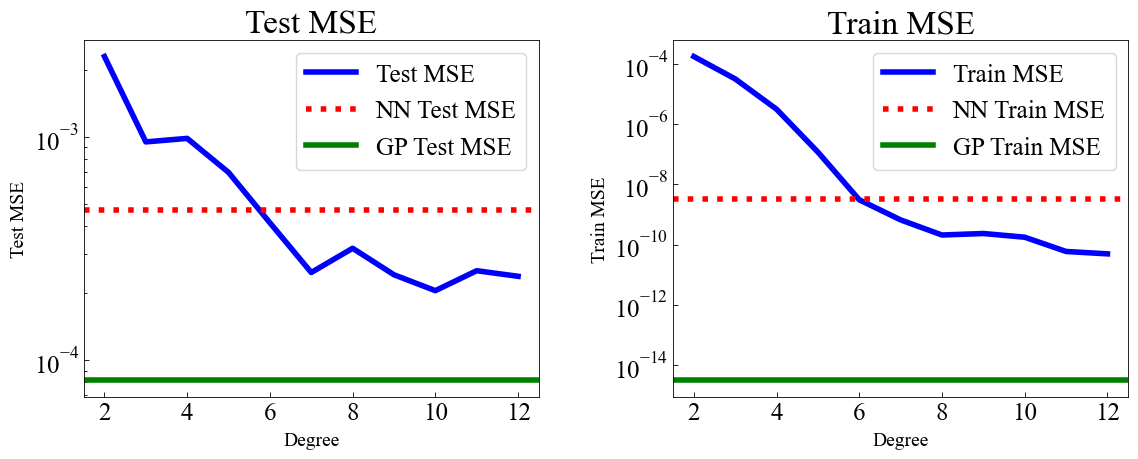

In [85]:
# visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

nn_train_mse = 3.171971844204862e-09
ax1.plot(degrees, test_mses, linewidth=4, color='b', label='Test MSE')
# ax1.plot(degrees, bound_mse_Cdd, label='Bound on MSE', linestyle='--')
ax1.axhline(y=nn_test_mse, linewidth=4, color='r', linestyle=':', label='NN Test MSE')
ax1.axhline(y=gp_test_mse, linewidth=4, color='g', linestyle='-', label='GP Test MSE')
ax1.set_xlabel('Degree')
ax1.set_ylabel('Test MSE')
ax1.set_title('Test MSE')
ax1.set_yscale('log')
ax1.legend()

ax2.plot(degrees, train_mses, linewidth=4, color='b', label='Train MSE')
ax2.axhline(y=nn_train_mse, linewidth=4, color='r', linestyle=':', label='NN Train MSE')
ax2.axhline(y=gp_train_mse, linewidth=4, color='g', linestyle='-', label='GP Train MSE')
ax2.set_xlabel('Degree')
ax2.set_ylabel('Train MSE')
ax2.set_title('Train MSE')
ax2.set_yscale('log')
ax2.legend()

plt.tight_layout()
plt.show()

fig.savefig("figs/mse_comparison.png")


In [ ]:
# visualizations - Classical vs Remez Bounds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(degrees, test_mses, linewidth=4, label='Test MSE', color='black')
ax1.plot(degrees, bound_mse_Cdd, linewidth=4, label='Classical Bound', linestyle='--', color='blue')
ax1.plot(degrees, bound_mse_remez, linewidth=4, label='Remez Bound', linestyle=':', color='red')
ax1.set_xlabel('Degree', fontsize=18)
ax1.set_ylabel('Test MSE', fontsize=18)
ax1.set_title('Test MSE vs Theoretical Bounds', fontsize=20)
ax1.set_yscale('log')
ax1.legend(fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

# make the lines thicker
ax2.plot(degrees, test_maes, linewidth=4, label='Test MAE', color='black')
ax2.plot(degrees, bound_abs_Cdd, linewidth=4, label='Classical Bound', linestyle='--', color='blue')
ax2.plot(degrees, bound_abs_remez, linewidth=4, label='Remez Bound', linestyle=':', color='red')
ax2.set_xlabel('Degree', fontsize=18)
ax2.set_ylabel('Test MAE', fontsize=18)
ax2.set_title('Test MAE vs Theoretical Bounds', fontsize=20)
ax2.set_yscale('log')
ax2.legend(fontsize=14)
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()
fig.savefig("figs/theoretical_bound.png")

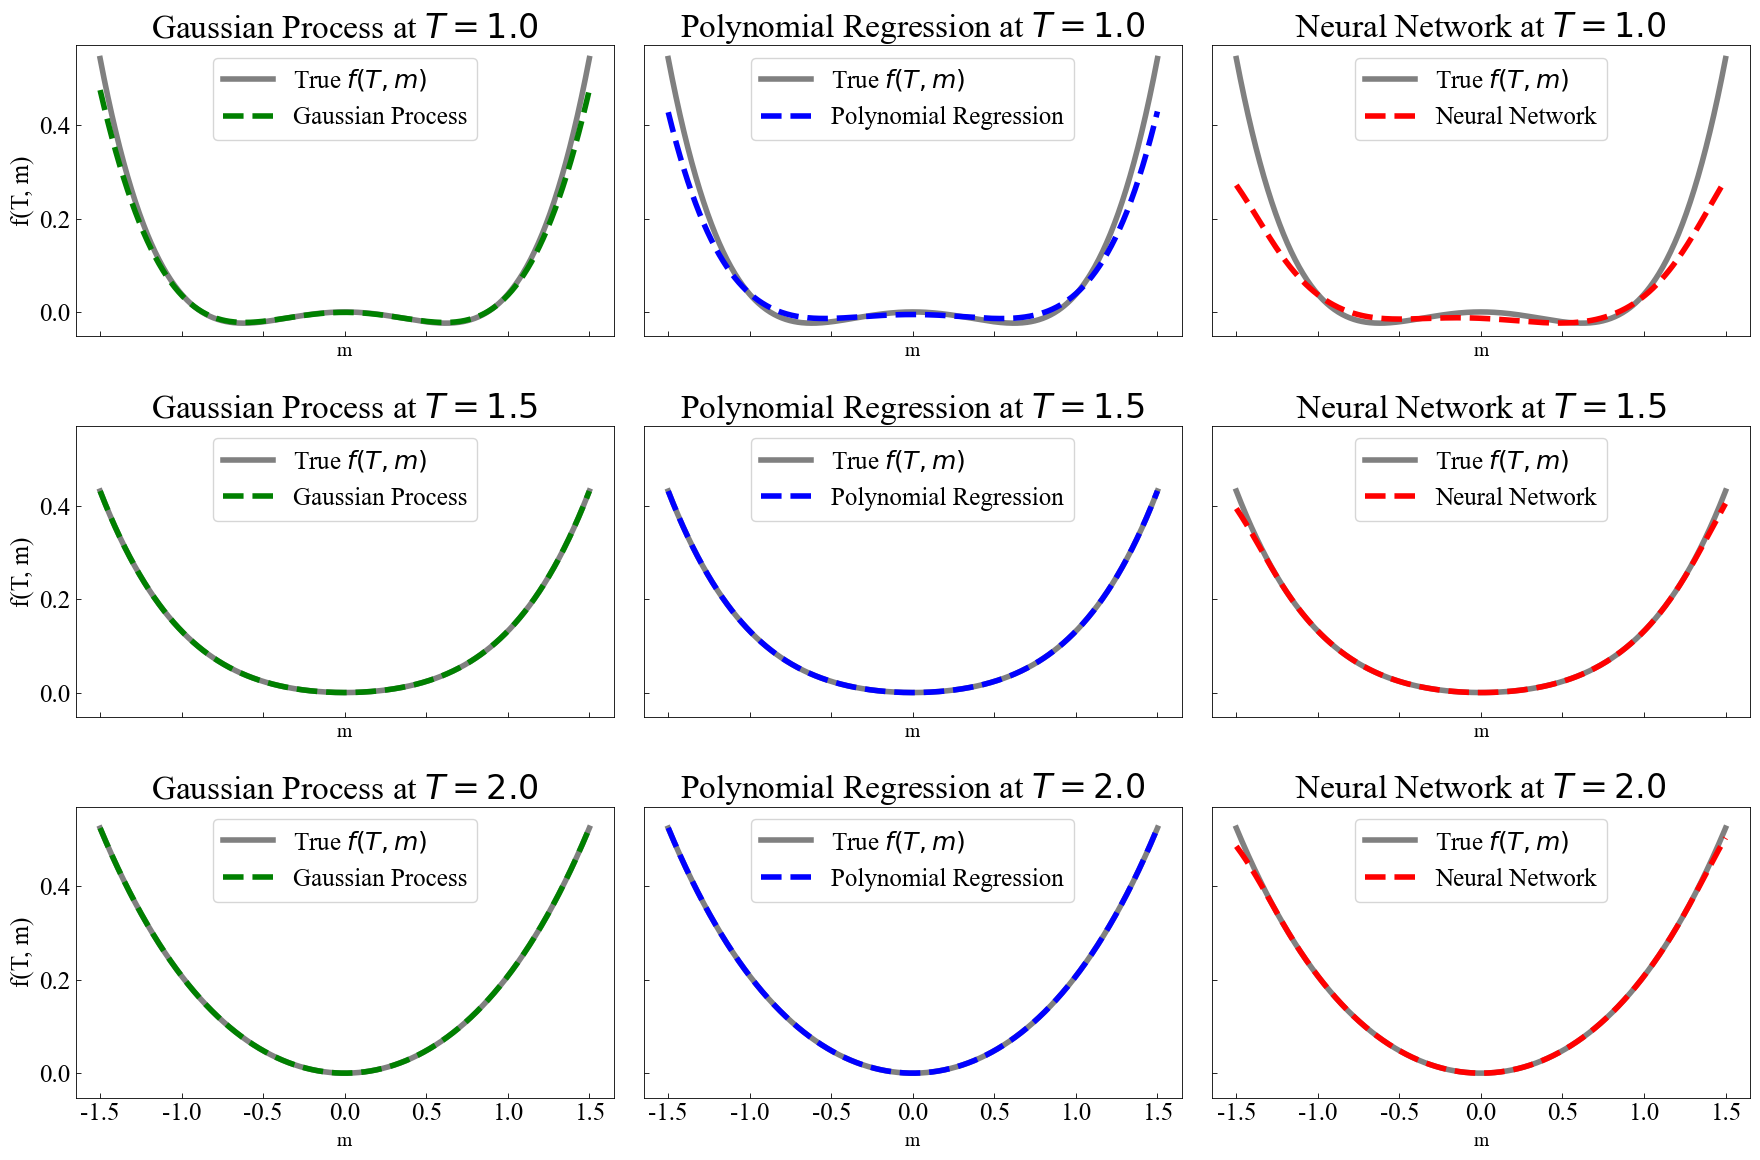

In [90]:
import matplotlib.pyplot as plt

T_vals = [1.0, 1.5, 2.0]
methods = ['Gaussian Process', 'Polynomial Regression', 'Neural Network']
colors = ['g', 'b', 'r']

fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

m_vals = np.linspace(-1.5, 1.5, 500)

for i, T_extrap in enumerate(T_vals):
    X_extrap = np.vstack([np.full_like(m_vals, T_extrap), m_vals]).T
    f_true = f(T_extrap, m_vals)
    # GP
    gp_pred = gp.predict(X_extrap)
    # Poly
    poly_pred = poly_model.predict(X_extrap)
    # NN
    nn_pred = mlp.predict(scaler.transform(X_extrap))
    nn_pred = (nn_pred * y_std) + y_mean

    preds = [gp_pred, poly_pred, nn_pred]
    for j, (pred, method, color) in enumerate(zip(preds, methods, colors)):
        ax = axs[i, j]
        ax.plot(m_vals, f_true, linewidth=4, color='gray', linestyle='-', label='True $f(T, m)$', zorder=1)
        ax.plot(m_vals, pred, color=color, linewidth=4, linestyle='--', label=method, zorder=2)
        ax.set_title(f"{method} at $T={T_extrap}$", fontsize=24)
        ax.set_xlabel("m", fontsize=14)
        if j == 0:
            ax.set_ylabel("f(T, m)", fontsize=18)
        ax.legend(fontsize=18)
        ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.show()